In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import os

In [2]:
DATA_FILE = os.path.join('../data', 'train.csv')

In [3]:
data = pd.read_csv(DATA_FILE, parse_dates=['pickup_datetime', 'dropoff_datetime'])

In [4]:
data.iloc[0:5]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
data.columns

Index([u'id', u'vendor_id', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'pickup_longitude', u'pickup_latitude',
       u'dropoff_longitude', u'dropoff_latitude', u'store_and_fwd_flag',
       u'trip_duration'],
      dtype='object')

In [6]:
data['pickup_hr'] = data['pickup_datetime'].dt.hour
data['pickup_min'] = data['pickup_datetime'].dt.minute
data['pickup_sec'] = data['pickup_datetime'].dt.second
data['pickup_day'] = data['pickup_datetime'].dt.dayofweek
data['pickup_date'] = data['pickup_datetime'].dt.day
data['pickup_mon'] = data['pickup_datetime'].dt.month
data['pickup_yr'] = data['pickup_datetime'].dt.year
data['quarter'] = data['pickup_datetime'].dt.quarter
data['weekday'] = (data['pickup_day'] < 5).astype(int)

In [7]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import datetime

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=datetime(2015, 12, 31),
                        end=datetime(2017, 1, 1))

In [8]:
holidays

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30',
               '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11',
               '2016-11-24', '2016-12-26'],
              dtype='datetime64[ns]', freq=None)

In [9]:
data['holiday'] = (data['pickup_datetime'].dt.date.astype('datetime64').isin(holidays)).astype(int)

/Users/Sumukh/Workspace/.virtualenvs/taxi/lib/python2.7/site-packages/pandas/core/internals.py:3224: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)


In [12]:
from haversine import haversine

In [13]:
def distance(positions):
    lats = [(positions[0], 0.0), (positions[2], 0.0)]
    longs = [(0.0, positions[1]), (0.0, positions[3])]
    dist = (haversine(lats[0], lats[1]) + haversine(longs[0], longs[1]))/1000
    return dist

In [14]:
y = data[[u'pickup_latitude', u'pickup_longitude', 
          u'dropoff_latitude', u'dropoff_longitude']]

data['h_dist'] = map(lambda pos: distance(pos), y.as_matrix())

In [15]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_min,pickup_sec,pickup_day,pickup_date,pickup_mon,pickup_yr,quarter,weekday,holiday,h_dist
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,24,55,0,14,3,2016,1,1,0,0.002208
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,43,35,6,12,6,2016,2,0,0,0.002944
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,35,24,1,19,1,2016,1,1,0,0.008913
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,32,31,2,6,4,2016,2,1,0,0.001721
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,30,55,5,26,3,2016,1,0,0,0.001203


In [16]:
data = data.assign(st_dist=lambda df: np.sqrt((df.pickup_longitude-df.dropoff_longitude)**2 + 
                                       (df.pickup_latitude-df.dropoff_latitude)**2))

In [17]:
data.columns

Index([u'id', u'vendor_id', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'pickup_longitude', u'pickup_latitude',
       u'dropoff_longitude', u'dropoff_latitude', u'store_and_fwd_flag',
       u'trip_duration', u'pickup_hr', u'pickup_min', u'pickup_sec',
       u'pickup_day', u'pickup_date', u'pickup_mon', u'pickup_yr', u'quarter',
       u'weekday', u'holiday', u'h_dist', u'st_dist'],
      dtype='object')

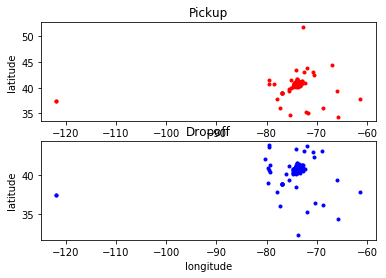

In [19]:
plt.subplot(2, 1, 1)
plt.plot(data['pickup_longitude'], data['pickup_latitude'], 'r.')
plt.ylabel('latitude')
plt.title('Pickup')
plt.subplot(2, 1, 2)
plt.plot(data['dropoff_longitude'], data['dropoff_latitude'], 'b.')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.title('Dropoff')
plt.show()

In [20]:
data['s_pickup_latitude'] = (data['pickup_latitude'] - data['pickup_latitude'].min())/(data['pickup_latitude'].max() - data['pickup_latitude'].min())
data['s_pickup_longitude'] = (data['pickup_longitude'] - data['pickup_longitude'].min())/(data['pickup_longitude'].max() - data['pickup_longitude'].min())

data['s_dropoff_latitude'] = (data['dropoff_latitude'] - data['dropoff_latitude'].min())/(data['dropoff_latitude'].max() - data['dropoff_latitude'].min())
data['s_dropoff_longitude'] = (data['dropoff_longitude'] - data['dropoff_longitude'].min())/(data['dropoff_longitude'].max() - data['dropoff_longitude'].min())

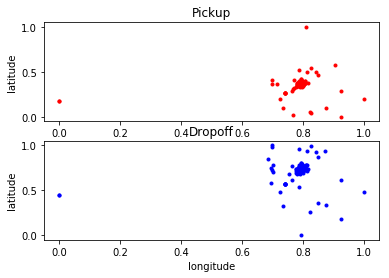

In [21]:
plt.subplot(2, 1, 1)
plt.plot(data['s_pickup_longitude'], data['s_pickup_latitude'], 'r.')
plt.ylabel('latitude')
plt.title('Pickup')
plt.subplot(2, 1, 2)
plt.plot(data['s_dropoff_longitude'], data['s_dropoff_latitude'], 'b.')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.title('Dropoff')
plt.show()

In [22]:
data['flag'] = (data['store_and_fwd_flag'] == 'Y').astype(int)

In [23]:
x = data[['id', 'flag']].groupby('flag')
x.groups

{0: Int64Index([      0,       1,       2,       3,       4,       5,       6,
                   7,       8,       9,
             ...
             1458634, 1458635, 1458636, 1458637, 1458638, 1458639, 1458640,
             1458641, 1458642, 1458643],
            dtype='int64', length=1450599),
 1: Int64Index([    348,     491,     610,     774,     846,     854,    1014,
                1031,    1115,    1336,
             ...
             1456708, 1456914, 1456966, 1457541, 1457553, 1457556, 1457670,
             1457897, 1458060, 1458416],
            dtype='int64', length=8045)}

In [24]:
x = data[['id', 'pickup_yr']].groupby('pickup_yr')
x.groups

{2016: Int64Index([      0,       1,       2,       3,       4,       5,       6,
                   7,       8,       9,
             ...
             1458634, 1458635, 1458636, 1458637, 1458638, 1458639, 1458640,
             1458641, 1458642, 1458643],
            dtype='int64', length=1458644)}

In [28]:
data['month_end'] = (data['pickup_datetime'].dt.is_month_end).astype(int)
data['month_start'] = (data['pickup_datetime'].dt.is_month_start).astype(int)

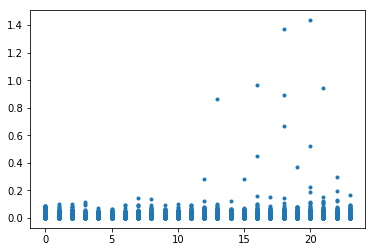

In [47]:
plt.plot(data['pickup_hr'], data['h_dist'], '.')
plt.show()

In [48]:
data.columns

Index([u'id', u'vendor_id', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'pickup_longitude', u'pickup_latitude',
       u'dropoff_longitude', u'dropoff_latitude', u'store_and_fwd_flag',
       u'trip_duration', u'pickup_hr', u'pickup_min', u'pickup_sec',
       u'pickup_day', u'pickup_date', u'pickup_mon', u'pickup_yr', u'quarter',
       u'weekday', u'holiday', u'h_dist', u'st_dist', u's_pickup_latitude',
       u's_pickup_longitude', u's_dropoff_latitude', u's_dropoff_longitude',
       u'flag', u'month_end', u'month_start'],
      dtype='object')

In [28]:
features = data[['id', 'vendor_id', 'passenger_count',
       'trip_duration', 'pickup_hr', 'pickup_min', 'pickup_sec',
       'pickup_day', 'pickup_date', 'pickup_mon', 'st_dist',
       's_pickup_latitude', 's_pickup_longitude', 's_dropoff_latitude',
       's_dropoff_longitude', 'flag', 'cityblock']]